CREATE FILE PATH

In [1182]:
import os
import time
import uuid

In [1183]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

CHECK THAT ALL PHYSICAL DEVICES WORK

In [1184]:
import tensorflow as tf
import cv2
import xml
import xmltodict
import json
import numpy as np
from matplotlib import pyplot as plt

In [1185]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [1186]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

LOAD IMAGES INTO TENSORFLOW DATA PIPELINE

In [1187]:
images = tf.data.Dataset.list_files('data/*/images/*.jpg')
images.as_numpy_iterator().next()

def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [1188]:
images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[ 41,  15,  16],
        [ 54,  25,  27],
        [ 70,  40,  40],
        ...,
        [125,  72,  66],
        [125,  72,  66],
        [124,  71,  65]],

       [[ 41,  15,  16],
        [ 54,  25,  27],
        [ 70,  40,  40],
        ...,
        [125,  72,  66],
        [124,  71,  65],
        [123,  70,  64]],

       [[ 41,  15,  16],
        [ 54,  25,  27],
        [ 70,  40,  40],
        ...,
        [124,  71,  65],
        [123,  70,  64],
        [122,  69,  63]],

       ...,

       [[  0,   1,   0],
        [  5,   6,   1],
        [ 12,  13,   8],
        ...,
        [187, 187, 179],
        [193, 190, 183],
        [197, 194, 185]],

       [[  0,   1,   0],
        [  7,   8,   3],
        [ 14,  15,  10],
        ...,
        [132, 133, 125],
        [135, 135, 127],
        [140, 140, 132]],

       [[  0,   1,   0],
        [  8,   9,   4],
        [ 16,  17,  12],
        ...,
        [130, 131, 125],
        [129, 129, 121],
        [132, 132, 124]]

VIEW RAW IMAGES WITH MATPLOTLIB

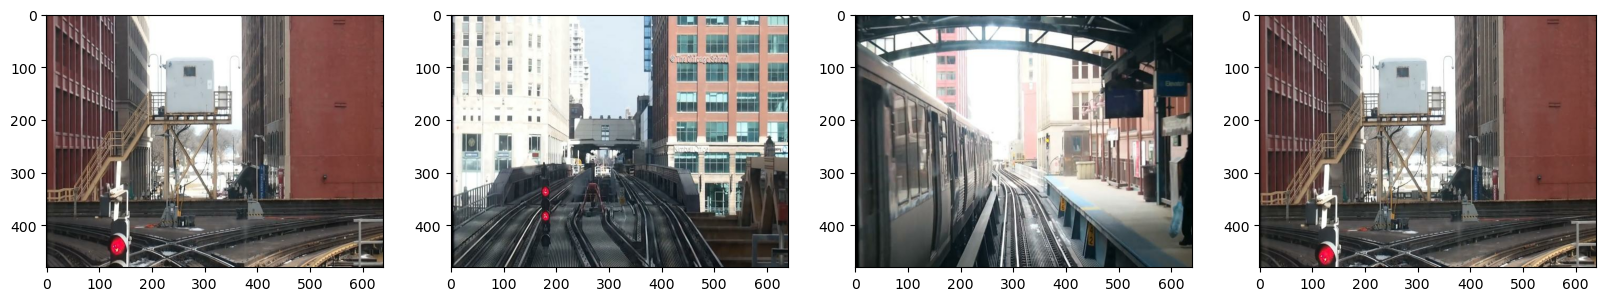

In [1189]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

ALBUMENTATIONS TRANSFORM PIPELINE

In [1190]:
import albumentations as alb

In [1191]:
augmentor = alb.Compose([ 
                        alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

TEST ALBUMENTATIONS WITH OPENCV AND JSON

In [1192]:
img = cv2.imread(os.path.join('data','train', 'images','youtube-0_jpg.rf.380c3c2f162dcde0d2bb19e8e4f4676f.jpg'))
with open(os.path.join('data', 'train', 'labels', 'youtube-0_jpg.rf.380c3c2f162dcde0d2bb19e8e4f4676f.xml'), 'r') as f:
    label = [xmltodict.parse(f.read())['annotation']]
label[0]['object']['bndbox']

{'xmin': '561', 'xmax': '589', 'ymin': '145', 'ymax': '269'}

EXTRACT COORDINATES

In [1193]:
coords = [0, 0, 0, 0]
coords[0] = int(label[0]['object']['bndbox']['xmin'])
coords[1] = int(label[0]['object']['bndbox']['ymin'])
coords[2] = int(label[0]['object']['bndbox']['xmax'])
coords[3] = int(label[0]['object']['bndbox']['ymax'])
coords

[561, 145, 589, 269]

In [1194]:
coords = list(np.divide(coords, [640, 480, 640, 480]))
coords

[0.8765625, 0.3020833333333333, 0.9203125, 0.5604166666666667]

APPLY AUGMENTATIONS

In [1195]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['signal light'])
augmented['bboxes']

[(0.8765625, 0.4395833333333333, 0.9203125, 0.6979166666666667)]

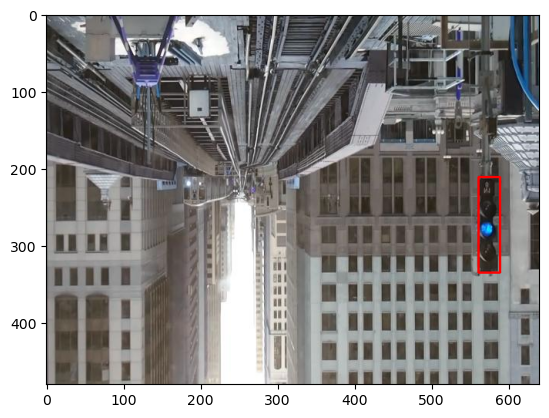

In [1196]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [640,480]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [640,480]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

BUILDING AUGMENTATION PIPELINE

In [1197]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.xml')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                [xmltodict.parse(f.read())['annotation']]

            coords[0] = int(label[0]['object']['bndbox']['xmin'])
            coords[1] = int(label[0]['object']['bndbox']['ymin'])
            coords[2] = int(label[0]['object']['bndbox']['xmax'])
            coords[3] = int(label[0]['object']['bndbox']['ymax'])
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    xml.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type


LOADING AUGMENTED IMAGES INTO TENSORFLOW DATASET

In [1200]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)
train_images.as_numpy_iterator().next()

array([[[0.60817   , 0.55751634, 0.52679735],
        [0.32254902, 0.36372548, 0.3107843 ],
        [0.25686276, 0.17385618, 0.08888883],
        ...,
        [0.46797377, 0.4405228 , 0.40915024],
        [0.4362745 , 0.42058823, 0.3990196 ],
        [0.39248502, 0.38856345, 0.37287718]],

       [[0.61405236, 0.5712418 , 0.5382353 ],
        [0.32058823, 0.35980392, 0.30686274],
        [0.26732025, 0.17712417, 0.09215681],
        ...,
        [0.4699348 , 0.4424838 , 0.41111127],
        [0.39117646, 0.3754902 , 0.35392156],
        [0.49379477, 0.4898732 , 0.47418693]],

       [[0.5977124 , 0.5683006 , 0.5297386 ],
        [0.33039215, 0.36764705, 0.31470588],
        [0.30032682, 0.19379085, 0.11666664],
        ...,
        [0.43496776, 0.40751678, 0.37614423],
        [0.4117647 , 0.39607844, 0.3745098 ],
        [0.352614  , 0.34869242, 0.33300614]],

       ...,

       [[0.6316994 , 0.5983661 , 0.55915034],
        [0.622549  , 0.59313726, 0.55196077],
        [0.46797383, 0

PREPARING LABELS

In [1201]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

LOAD LABELS INTO TENSORFLOW DATASET

In [1202]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))